# Identify SS using PARSIM-K


In [113]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import joblib

from __future__ import division


# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *
from sippy import functionsetSIM as fsetSIM

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a Dataset

In [114]:
# Load experimental data from .mat files
from scipy.io import loadmat

# Path to experimental data
data_path = '../experimental_data/'


# Load test data (files ending with _2)
# Use the first 4000 points of training as a separate test set
T1_full = loadmat(data_path + 'T1_ident_3.mat')
T2_full = loadmat(data_path + 'T2_ident_3.mat')
T4_full = loadmat(data_path + 'T4_ident_3.mat')
u1_full = loadmat(data_path + 'u1_ident_3.mat')
u2_full = loadmat(data_path + 'u2_ident_3.mat')
u3_full = loadmat(data_path + 'u3_ident_3.mat')

T1_train = {'T1': T1_full['T1'][:4000][::10]}
T2_train = {'T2': T2_full['T2'][:4000][::10]}
T4_train = {'T4': T4_full['T4'][:4000][::10]}
u1_train = {'u1': u1_full['u1'].reshape(-1,1)[:4000][::10]}
u2_train = {'u2': u2_full['u2'].reshape(-1,1)[:4000][::10]}
u3_train = {'u3': u3_full['u3'].reshape(-1,1)[:4000][::10]}
# Test set: every 10th sample after first 4000
T1_test = {'T1': T1_full['T1'][4000:][::10]}
T2_test = {'T2': T2_full['T2'][4000:][::10]}
T4_test = {'T4': T4_full['T4'][4000:][::10]}
u1_test = {'u1': u1_full['u1'].reshape(-1,1)[4000:][::10]}
u2_test = {'u2': u2_full['u2'].reshape(-1,1)[4000:][::10]}
u3_test = {'u3': u3_full['u3'].reshape(-1,1)[4000:][::10]}

print("Experimental data loaded successfully!")
print(f"Training data variables: {list(T1_train.keys())}")
print(f"Test data variables: {list(T1_test.keys())}")

train = {
    'Y': np.concatenate([T1_train['T1'], T2_train['T2'], T4_train['T4']], axis=1),
    'U': np.concatenate([u1_train['u1'], u2_train['u2'], u3_train['u3']], axis=1)
}
test = {
    'Y': np.concatenate([T1_test['T1'], T2_test['T2'], T4_test['T4']], axis=1),
    'U': np.concatenate([u1_test['u1'], u2_test['u2'], u3_test['u3']], axis=1)
}


Experimental data loaded successfully!
Training data variables: ['T1']
Test data variables: ['T1']


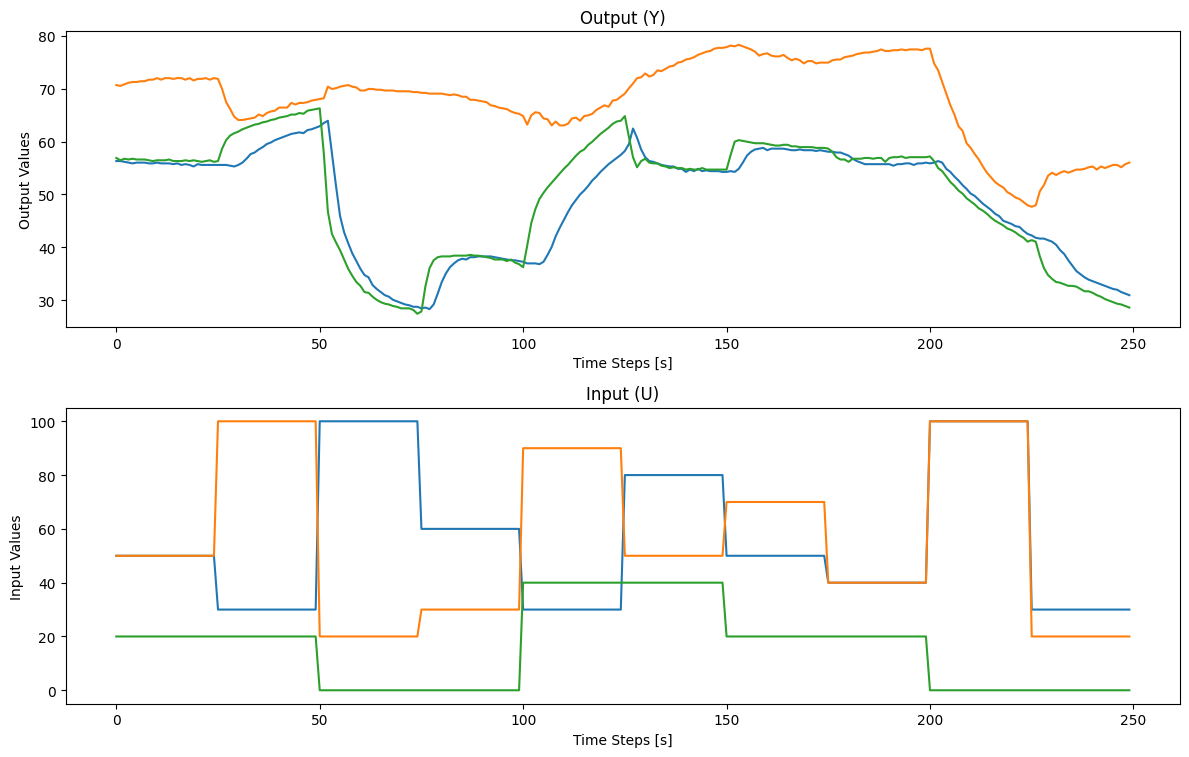

In [115]:
part = 250

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train["Y"][:part])
plt.title("Output (Y)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Output Values")

plt.subplot(2, 1, 2)
plt.plot(train["U"][:part])
plt.title("Input (U)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Values")

plt.tight_layout(rect=[0, 0, 1, 0.96])

In [116]:
# Estimate noise variance for train and test data by differencing adjacent samples (per-output variable)

# Calculate output differences (could be used as noise proxy if true noise unavailable)
train_y_diff = np.diff(train['Y'], axis=0)
test_y_diff = np.diff(test['Y'], axis=0)

# Estimate the variance for each output variable (column)
train_noise_variance = np.var(train_y_diff, axis=0)
test_noise_variance = np.var(test_y_diff, axis=0)

print("Estimated noise variance in train data (per output):", train_noise_variance)
print("Estimated noise variance in test data (per output):", test_noise_variance)




Estimated noise variance in train data (per output): [0.9009747  0.36389997 1.65694062]
Estimated noise variance in test data (per output): [0.62769008 0.44030246 1.16896936]


In [117]:
# Estimate noise variance for train and test data, using only steps 50 to 250

start_idx = 50
end_idx = 250

# Restrict to steps 50 to 250
train_y_segment = train['Y'][start_idx:end_idx]
test_y_segment = test['Y'][start_idx:end_idx]

# Calculate output differences over the selected window
train_y_diff = np.diff(train_y_segment, axis=0)
test_y_diff = np.diff(test_y_segment, axis=0)

# Estimate the variance for each output variable (column)
train_noise_variance = np.var(train_y_diff, axis=0)
test_noise_variance = np.var(test_y_diff, axis=0)

print(f"Estimated noise variance in train data (per output, steps {start_idx}-{end_idx}):", train_noise_variance)
print(f"Estimated noise variance in test data (per output, steps {start_idx}-{end_idx}):", test_noise_variance)


Estimated noise variance in train data (per output, steps 50-250): [1.09736619 0.47884902 2.02367773]
Estimated noise variance in test data (per output, steps 50-250): [0.22132129 0.45340408 0.64231059]


In [118]:
train_noise_variance+test_noise_variance/2

array([1.20802684, 0.70555106, 2.34483302])

In [119]:
# Load the scalers with NumPy version compatibility workaround
# This handles the case where pickle files were created with NumPy 2.0+ but loaded with NumPy < 2.0
import sys
import types

# Create a compatibility shim: make numpy._core available as an alias to numpy.core
# This allows pickle files created with NumPy 2.0+ to load in NumPy < 2.0 environments
if 'numpy._core' not in sys.modules:
    import numpy.core
    import numpy.core.multiarray
    import numpy.core.umath
    import numpy.core.numeric
    
    # Create fake modules that redirect to numpy.core equivalents
    numpy._core = types.ModuleType('numpy._core')
    numpy._core.multiarray = types.ModuleType('numpy._core.multiarray')
    numpy._core.umath = types.ModuleType('numpy._core.umath')
    numpy._core.numeric = types.ModuleType('numpy._core.numeric')
    
    # Copy attributes from numpy.core to numpy._core
    for attr in dir(numpy.core):
        if not attr.startswith('_'):
            try:
                setattr(numpy._core, attr, getattr(numpy.core, attr))
            except:
                pass
    
    # Copy submodule attributes
    for submod_name in ['multiarray', 'umath', 'numeric']:
        source = getattr(numpy.core, submod_name)
        target = getattr(numpy._core, submod_name)
        for attr in dir(source):
            if not attr.startswith('_'):
                try:
                    setattr(target, attr, getattr(source, attr))
                except:
                    pass
    
    sys.modules['numpy._core'] = numpy._core
    sys.modules['numpy._core.multiarray'] = numpy._core.multiarray
    sys.modules['numpy._core.umath'] = numpy._core.umath
    sys.modules['numpy._core.numeric'] = numpy._core.numeric

# Now load the scalers
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')

# Scale the data
train["Y"] = scaler.transform(train["Y"])
train["U"] = scalerU.transform(train["U"])

test["Y"] = scaler.transform(test["Y"])
test["U"] = scalerU.transform(test["U"])

## Identification using PARSIM-K
```python

In [120]:
y_tot = train["Y"].copy()
U = train["U"].T.copy()

In [121]:
# order 11 wins
sys_id = system_identification(y_tot.copy(), U.copy(), 'PARSIM-K', SS_fixed_order = 3)
#sys_id = system_identification(y_tot, U, method, SS_fixed_order = 2 )

In [122]:
sys_id.A

array([[ 0.95769957,  0.05325093,  0.0597232 ],
       [ 0.01789423,  0.93206905, -0.04888153],
       [-0.04696441,  0.10702031,  0.64021648]])

In [123]:
append = "_parsimK"
np.save('../data/A' + append + '.npy', sys_id.A)
np.save('../data/B' + append + '.npy', sys_id.B)
np.save('../data/C' + append + '.npy', sys_id.C)

In [124]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, test["U"].T, np.linalg.pinv(sys_id.C)@test["Y"][0].reshape(-1, 1)
)

In [125]:
# Average MAE across all outputs for order 3: 1.309998
# Average MAE across all outputs for order 4: 1.327874
# Average MAE across all outputs for order 5: 1.368082
# Average MAE across all outputs for order 6: 1.461144
# Average MAE across all outputs for order 7: 1.331847
# Average MAE across all outputs for order 8: 1.511770
# Average MAE across all outputs for order 9: 1.673568
# Average MAE across all outputs for order 10: 1.757821
# Average MAE across all outputs for order 11: 2.200758
# Average MAE across all outputs for order 12: 2.043397
# Average MAE across all outputs for order 13: 1.461903
# Average MAE across all outputs for order 14: 1.474182
# Average MAE across all outputs for order 15: 1.645130
# Average MAE across all outputs for order 16: 1.615261
# Average MAE across all outputs for order 17: 2.145387
# Average MAE across all outputs for order 18: 1.418835
# Average MAE across all outputs for order 19: 1.895619
# Average MAE across all outputs for order 20: 1.571884
# Average MAE across all outputs for order 21: 1.835593
# Average MAE across all outputs for order 22: 2.063237
# Average MAE across all outputs for order 23: 2.027891
# Average MAE across all outputs for order 24: 1.925647
# Average MAE across all outputs for order 25: 2.070116
# Average MAE across all outputs for order 26: 1.828373
# Average MAE across all outputs for order 27: 2.353421
# Average MAE across all outputs for order 28: 2.189060
# Average MAE across all outputs for order 29: 2.064741

In [133]:
# for j in range(3,30):
#     sys_id = system_identification(y_tot.copy(), U.copy(), 'PARSIM-K', SS_fixed_order = j, SS_f = 30, SS_p = 30)
# #sys_id = system_identification(y_tot, U, method, SS_fixed_order = 2 )
#     xid, yid = fsetSIM.SS_lsim_process_form(
#             sys_id.A, sys_id.B, sys_id.C, sys_id.D, test["U"].T, np.linalg.pinv(sys_id.C)@test["Y"][0].reshape(-1, 1)
#         )
#     # Calculate Mean Squared Error (MSE) for each output between identified and test
#     from sklearn.metrics import mean_squared_error

#     # yid has shape (outputs, timesteps); test["Y"] has shape (timesteps, outputs)
#     # So compare yid.T and test["Y"]
#     from sklearn.metrics import mean_absolute_error

#     mae_outputs = []
#     for i in range(yid.shape[0]):
#         mae = mean_absolute_error(test["Y"][:, i], yid[i, :])
#         mae_outputs.append(mae)

#     # If you want the average MAE across all outputs:
#     mean_mae = sum(mae_outputs) 
#     print(f"Average MAE across all outputs for order {j}: {mean_mae:.6f}")

Average MAE across all outputs for order 3: 1.311332
Average MAE across all outputs for order 4: 1.329086
Average MAE across all outputs for order 5: 1.370049
Average MAE across all outputs for order 6: 1.452734
Average MAE across all outputs for order 7: 1.338532
Average MAE across all outputs for order 8: 1.504837
Average MAE across all outputs for order 9: 1.699271
Average MAE across all outputs for order 10: 1.788337
Average MAE across all outputs for order 11: 2.230756
Average MAE across all outputs for order 12: 2.079008
Average MAE across all outputs for order 13: 1.481039
Average MAE across all outputs for order 14: 1.486670
Average MAE across all outputs for order 15: 1.651536
Average MAE across all outputs for order 16: 1.638518
Average MAE across all outputs for order 17: 2.186531
Average MAE across all outputs for order 18: 1.440671
Average MAE across all outputs for order 19: 1.946793
Average MAE across all outputs for order 20: 1.583467
Average MAE across all outputs for 

3 = 1.054

10 = 0.9337

13 = 0.904

14 = 0.903379

15 = 0.903037

16 = 0.92811

17 = 0.906

20 = 0.935

30 = 0.935

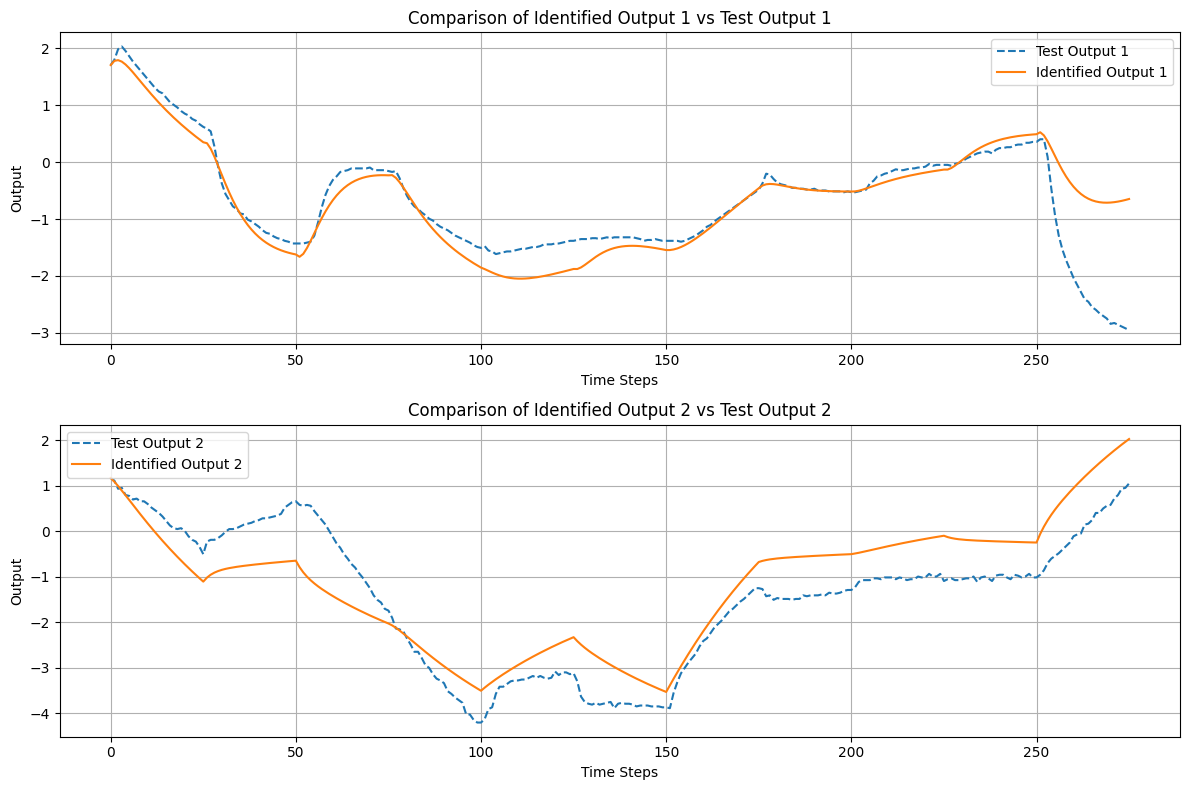

In [127]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(test["Y"][:, 0], label="Test Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Test Output 1")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(test["Y"][:, 1], label="Test Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Test Output 2")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [128]:
# Compute error and variance for test set
test_error = test["Y"].T - yid  # test["Y"]: shape (n_samples, n_outputs), yid: shape (n_outputs, n_samples)
test_mse = np.mean(test_error ** 2, axis=1)
test_mae = np.mean(np.abs(test_error), axis=1)
avg_mae = np.sum(test_mae)
print("Test output error variances (MSE) for each output:")
for i, mse in enumerate(test_mse):
    print(f"Output {i+1}: {mse}")
print(f"Mean Absolute Error (MAE) averaged over all outputs: {avg_mae}")


Test output error variances (MSE) for each output:
Output 1: 0.30918196630920064
Output 2: 0.6090847784326435
Output 3: 0.31651648846073355
Mean Absolute Error (MAE) averaged over all outputs: 1.3177825319962089


In [129]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, train["U"].T, np.linalg.pinv(sys_id.C)@train["Y"][0].reshape(-1, 1)#sys_id.x0
    )

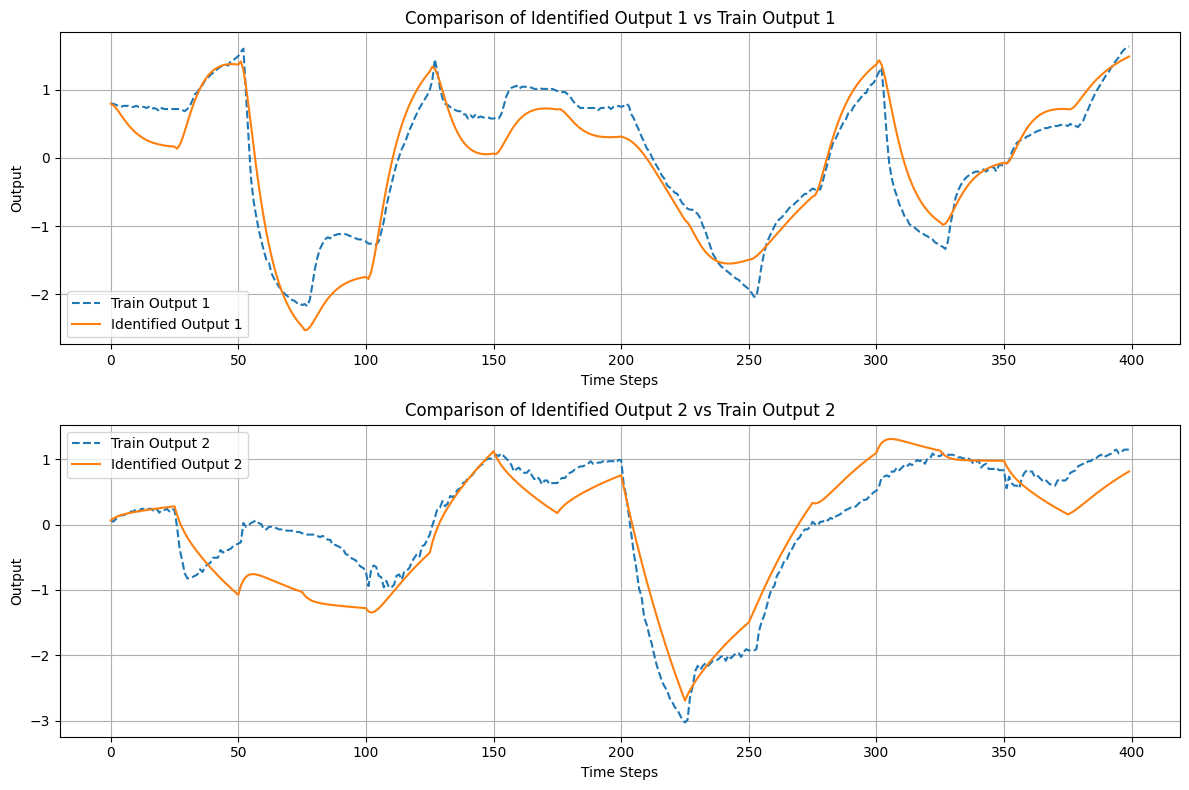

In [130]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train["Y"][:, 0], label="Train Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Train Output 1")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(train["Y"][:, 1], label="Train Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Train Output 2")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [131]:

# Compute error and variance for train set
# xid, yid computed above for training data
train_error = train["Y"].T - yid  # train["Y"]: (n_samples, n_outputs), yid: (n_outputs, n_samples)
train_mse = np.mean(train_error ** 2, axis=1)
print("\nTrain output error variances (MSE) for each output:")
for i, mse in enumerate(train_mse):
    print(f"Output {i+1}: {mse}")



Train output error variances (MSE) for each output:
Output 1: 0.1353049217177863
Output 2: 0.2009095980769445
Output 3: 0.09916343578780751


In [132]:

# Mean squared error of all test predictions (all outputs, all time steps)
overall_test_mse = np.mean((test["Y"].T - yid) ** 2)
print(f"\nOverall test prediction MSE (all outputs): {overall_test_mse}")





ValueError: operands could not be broadcast together with shapes (3,276) (3,400) 

In [ ]:
scaler.mean_

array([50.89195295, 73.83772211, 52.23040589])

In [ ]:
class KF():
    def __init__(self, A, B, C, x0, P0, Q, R):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0  
        
    def predict(self, u):
        self.x = self.A @ self.x.reshape(-1,1) + self.B @ u.reshape(-1,1)
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.x, self.P
    
    def update(self, y):
        y_pred = self.C@self.x.reshape(-1,1)
        S = self.C @ self.P @ self.C.T + self.R
        K = self.P @ self.C.T @ np.linalg.inv(S)
        self.x = self.x + K @ (y - y_pred.T).T
        self.P = (np.eye(self.P.shape[0]) - K @ self.C) @ self.P
        
    def step(self, u, y):
        self.predict(u)
        self.update(y)
        return self.x

In [ ]:
0.22943427007633202-np.mean([0.00049984, 0.00098101, 0.0005311])

0.22876362007633202

In [ ]:
A = sys_id.A
B = sys_id.B
C = sys_id.C
D = sys_id.D

nx, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]
Q = np.block([
    [np.eye(nx) * 0.1,  np.zeros((nx, nd))],   # Trust state model
    [np.zeros((nd, nx)), np.eye(nd) * 0.1]      # Disturbance adapts fast
])
R = np.eye(ny)*0.5
P0 = np.eye(nx+nd)


A_ = np.block([
    [A, np.zeros((nx, nd))],
    [np.zeros((nd, nx)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
C_ = np.hstack([
    C, np.eye(nd),
])
# Initialization as inverse mapping of first point in test data plus zeros for disturbance
x0_state = np.linalg.pinv(C) @ test["Y"][0].reshape(-1, 1)
x0 = np.vstack([np.zeros((nx, 1)), np.zeros((nd, 1))])

In [ ]:
KalmanFilter = KF(A_, B_, C_, x0, P0, Q, R)

In [ ]:
# Assume you have test data as U_test (shape: [timesteps, nu]), Y_test (shape: [timesteps, ny])
# We'll run predictions using the KF defined above.

X_pred = []
Y_pred = []

x_est = x0.copy()
P_est = P0.copy()

for t in range(test["U"].shape[0]):
    u_t = test["U"][t]
    y_t = test["Y"][t]
    # Predict step
    x_pred = KalmanFilter.step(u_t, y_t)
    # Optionally, update with measurement if available (e.g., Y_test[t])
    # KF.update(Y_test[t])
    X_pred.append(x_pred.flatten())
    y_hat = C_ @ x_pred
    Y_pred.append(y_hat.flatten())

X_pred = np.array(X_pred)  # shape: [timesteps, nx+nd]
Y_pred = np.array(Y_pred)  # shape: [timesteps, ny+nd]


In [ ]:
B.shape

(11, 3)

In [ ]:
u_t, y_t

(array([-0.02772039, -0.53595771,  0.        ]),
 array([0.14985103, 1.30316024, 0.0474471 ]))

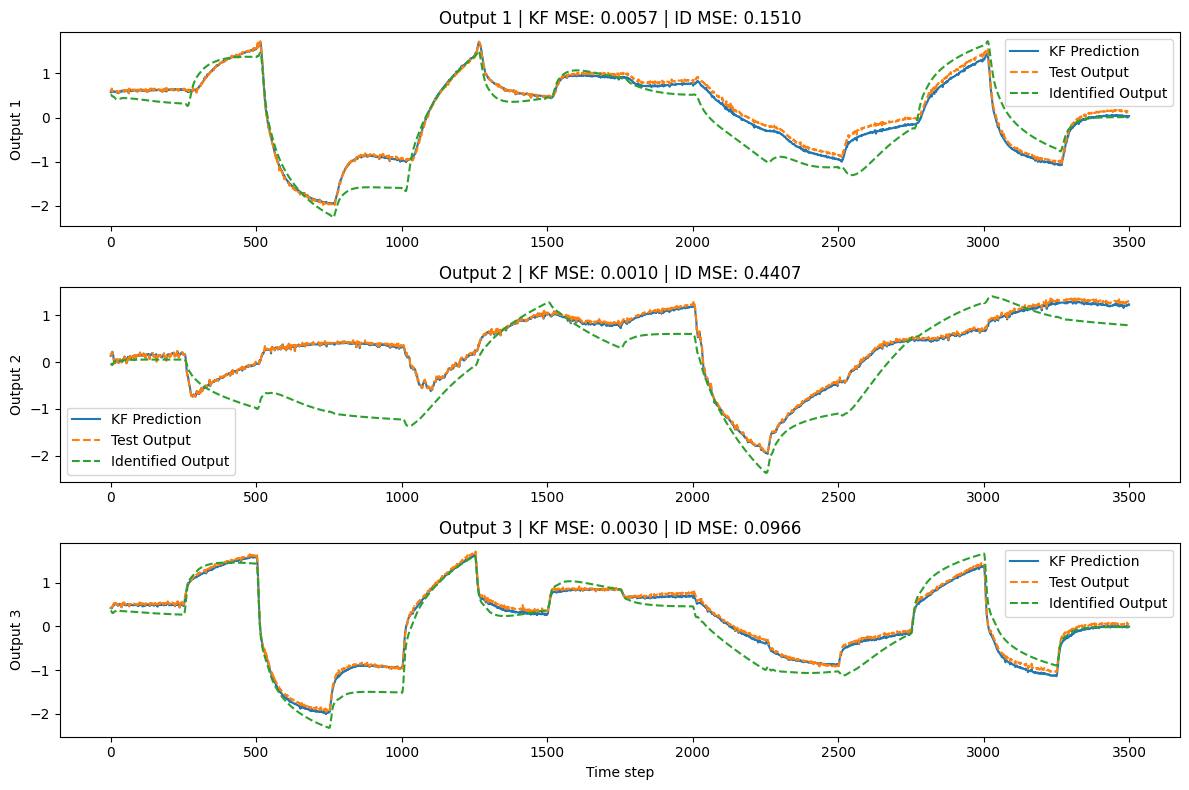

MSE (KF Prediction vs Test Output) per output: [0.00566343 0.00097044 0.00303778]
MSE (Identified Output vs Test Output) per output: [0.15098137 0.44074642 0.09657502]


In [ ]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(12, 8))
mse_kf = []
mse_id = []
for i in range(Y_pred.shape[1]):
    plt.subplot(Y_pred.shape[1], 1, i + 1)
    plt.plot(Y_pred[:, i], label="KF Prediction", linestyle='-')
    plt.plot(test["Y"][:, i], label="Test Output", linestyle='--')
    plt.plot((yid[i,:]),label="Identified Output",linestyle='--')
    plt.ylabel(f"Output {i+1}")
    plt.legend()
    
    # Compute MSEs
    mse_kf_i = np.mean((Y_pred[:, i] - test["Y"][:, i]) ** 2)
    mse_id_i = np.mean((yid[i,:] - test["Y"][:, i]) ** 2)
    mse_kf.append(mse_kf_i)
    mse_id.append(mse_id_i)
    plt.title(f"Output {i+1} | KF MSE: {mse_kf_i:.4f} | ID MSE: {mse_id_i:.4f}")

plt.xlabel("Time step")
plt.tight_layout()
plt.show()

print("MSE (KF Prediction vs Test Output) per output:", np.array(mse_kf))
print("MSE (Identified Output vs Test Output) per output:", np.array(mse_id))


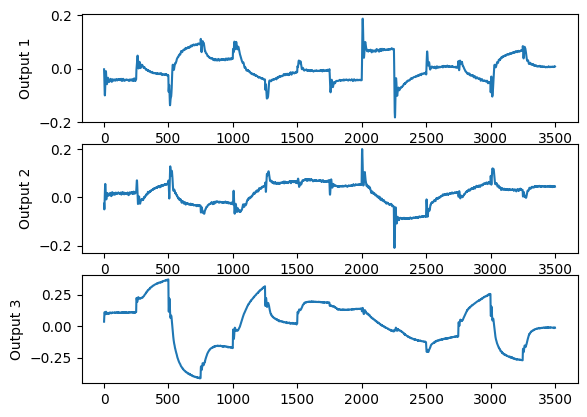

In [ ]:
for i in range(Y_pred.shape[1]):
    plt.subplot(Y_pred.shape[1], 1, i + 1)
    plt.plot(X_pred[:, nx-3+i], label="KF Prediction", linestyle='-')
    plt.ylabel(f"Output {i+1}")

In [ ]:
MSE (KF Prediction vs Test Output) per output: [0.09810949 0.28146617 0.05103627]
MSE (Identified Output vs Test Output) per output: [0.15098137 0.44074642 0.09657502]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (501950343.py, line 1)

In [ ]:
KalmanFilter.x

array([[-0.07647067],
       [-0.17287003],
       [ 0.05065342],
       [ 0.00389638],
       [ 0.04001154],
       [-0.01534877],
       [ 0.03807519],
       [-0.02915563],
       [ 0.00811721],
       [ 0.043718  ],
       [-0.0124255 ],
       [ 0.11757866],
       [ 0.07479011],
       [ 0.0535183 ]])